In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
import pandas as pd
import numpy as np
from scipy import stats as sci_stat
import statistics as stats
import math
import pickle

df = pd.read_csv('../Walt_disney_movie_dataset.csv')


In [3]:

def handle_missing_values(data: list):
    replace = stats.median(data)
    for i in range(len(data)):
        if data[i] == 0:
            data[i] = replace
    return data

def convert_one_item_2dlist_2oneDlist(ls: list[list]):
    for i in range(len(ls)):
        ls[i] = ls[i][0]
    return ls

def min_max_scaler(data:list):
    maximum = max(data)
    minimum = min(data)
    for i in range(len(data)):
        data[i] = (data[i] - minimum)/(maximum-minimum)
    return data

def discretization(data:list, n: int):
    dmin = min(data)
    dmax = max(data)
    thresh = []
    thresh.append(dmin)
    segment_size = math.ceil((dmax - dmin)/n)
    for i in range(n):
        thresh.append(thresh[i]+segment_size)
    
    for j in range(len(data)):
        for i in range(n+1):
            if(data[j] <= thresh[i]):
                data[j] = i+1
                break
    return data


In [4]:
running_time = df["Running time (int)"]
production_company = df["Production company"]
budget = df["Budget (float)"]
country = df["Country"]
language = df["Language"]
release_date = df["Release date (datetime)"]
box_office = df["Box office (float)"]

box_office = box_office.fillna(0)

budget = budget.fillna(0)
release_date = release_date.fillna("0000-00-00")
running_time = running_time.fillna(0)
country = country.fillna(method="ffill")
country = country.fillna(method="bfill")
language = language.fillna(method="ffill")
language = language.fillna(method="bfill")
production_company = production_company.fillna(method="ffill")
production_company = production_company.fillna(method="bfill")

label_encoder = LabelEncoder()
language = label_encoder.fit_transform(language)
language = pd.DataFrame({'Language': language.tolist()})

country = label_encoder.fit_transform(country)
country = pd.DataFrame({'Country': country.tolist()})

production_company = label_encoder.fit_transform(production_company)
production_company = pd.DataFrame({'Production Company': production_company.tolist()})

release_year = pd.DataFrame({"Release Year": pd.DataFrame(release_date.str.split('-',expand=True)).get(0)})
release_month = pd.DataFrame({"Release Month": pd.DataFrame(release_date.str.split('-',expand=True)).get(1)})
release_day = pd.DataFrame({"Release Day": pd.DataFrame(release_date.str.split('-',expand=True)).get(2)})

budget = pd.DataFrame({'Budget (float)': handle_missing_values(budget.values.tolist())})
running_time = pd.DataFrame({'Running time (int)': handle_missing_values(running_time.values.tolist())})
release_year = pd.DataFrame({ 'Release Year': handle_missing_values(convert_one_item_2dlist_2oneDlist(release_year.astype(int).values.tolist()))}).convert_dtypes(convert_integer=True)
release_month = pd.DataFrame({'Release Month': handle_missing_values(convert_one_item_2dlist_2oneDlist(release_month.astype(int).values.tolist()))}).convert_dtypes(convert_integer=True)
release_day = pd.DataFrame({'Release Day': handle_missing_values(convert_one_item_2dlist_2oneDlist(release_day.astype(int).values.tolist()))}).convert_dtypes(convert_integer=True)

box_office = pd.DataFrame({'Box Office (float)': handle_missing_values(box_office.values.tolist())}) 

data_subset = pd.concat([running_time, production_company, budget, country, language, release_year,release_month,release_day],axis=1)
type(data_subset)
data_subset


,Running time (int),Production Company,Budget (float),Country,Language,Release Year,Release Month,Release Day
0,41.0,3,7750000.0,7,1,1937.0,5.0,19
1,83.0,3,1490000.0,7,1,1937.0,12.0,21
2,88.0,3,2600000.0,7,1,1940.0,2.0,7
3,126.0,3,2280000.0,7,1,1940.0,11.0,13
4,74.0,3,600000.0,7,1,1941.0,6.0,27
...,...,...,...,...,...,...,...,...
447,96.0,0,7750000.0,7,1,1996.5,6.5,17
448,96.0,2,28000000.0,7,1,1993.0,7.0,16
449,96.0,2,7750000.0,7,1,1996.5,6.5,17
450,96.0,2,7750000.0,7,1,1996.5,6.5,17


In [5]:

label = box_office.values.tolist()
label = convert_one_item_2dlist_2oneDlist(label)
res = sci_stat.zscore(label, nan_policy= 'omit')
label = res.tolist()
label = discretization(label, 4)
sales_label_map = {1: 'very high sales', 2: 'high sales', 
3: 'moderate sales', 4: 'low sales', 5: 'very low sales'}

pd.DataFrame({"label": label})

,label
0,2
1,2
2,2
3,2
4,2
...,...
447,2
448,2
449,2
450,2


In [6]:
x_train, x_test, y_train, y_test = train_test_split(data_subset, label, test_size=0.20)

In [7]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(x_train, y_train)


In [8]:
fileName = 'DT-classifier.sav'
pickle.dump(clf, open(fileName, 'wb'))

In [9]:
y_pred = clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.8791208791208791

[Text(0.4230769230769231, 0.875, 'Budget <= 82105000.0\nentropy = 0.483\nsamples = 361\nvalue = [1, 334, 16, 9, 1]\nclass = high sales'),
 Text(0.15384615384615385, 0.625, 'Release Year <= 2018.5\nentropy = 0.033\nsamples = 295\nvalue = [1, 294, 0, 0, 0]\nclass = high sales'),
 Text(0.07692307692307693, 0.375, 'entropy = 0.0\nsamples = 277\nvalue = [0, 277, 0, 0, 0]\nclass = high sales'),
 Text(0.23076923076923078, 0.375, 'Running Time <= 80.5\nentropy = 0.31\nsamples = 18\nvalue = [1, 17, 0, 0, 0]\nclass = high sales'),
 Text(0.15384615384615385, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0, 0, 0, 0]\nclass = very high sales'),
 Text(0.3076923076923077, 0.125, 'entropy = 0.0\nsamples = 17\nvalue = [0, 17, 0, 0, 0]\nclass = high sales'),
 Text(0.6923076923076923, 0.625, 'Budget <= 145000000.0\nentropy = 1.417\nsamples = 66\nvalue = [0, 40, 16, 9, 1]\nclass = high sales'),
 Text(0.5384615384615384, 0.375, 'Release Day <= 27.0\nentropy = 0.706\nsamples = 26\nvalue = [0, 21, 5, 0, 0]

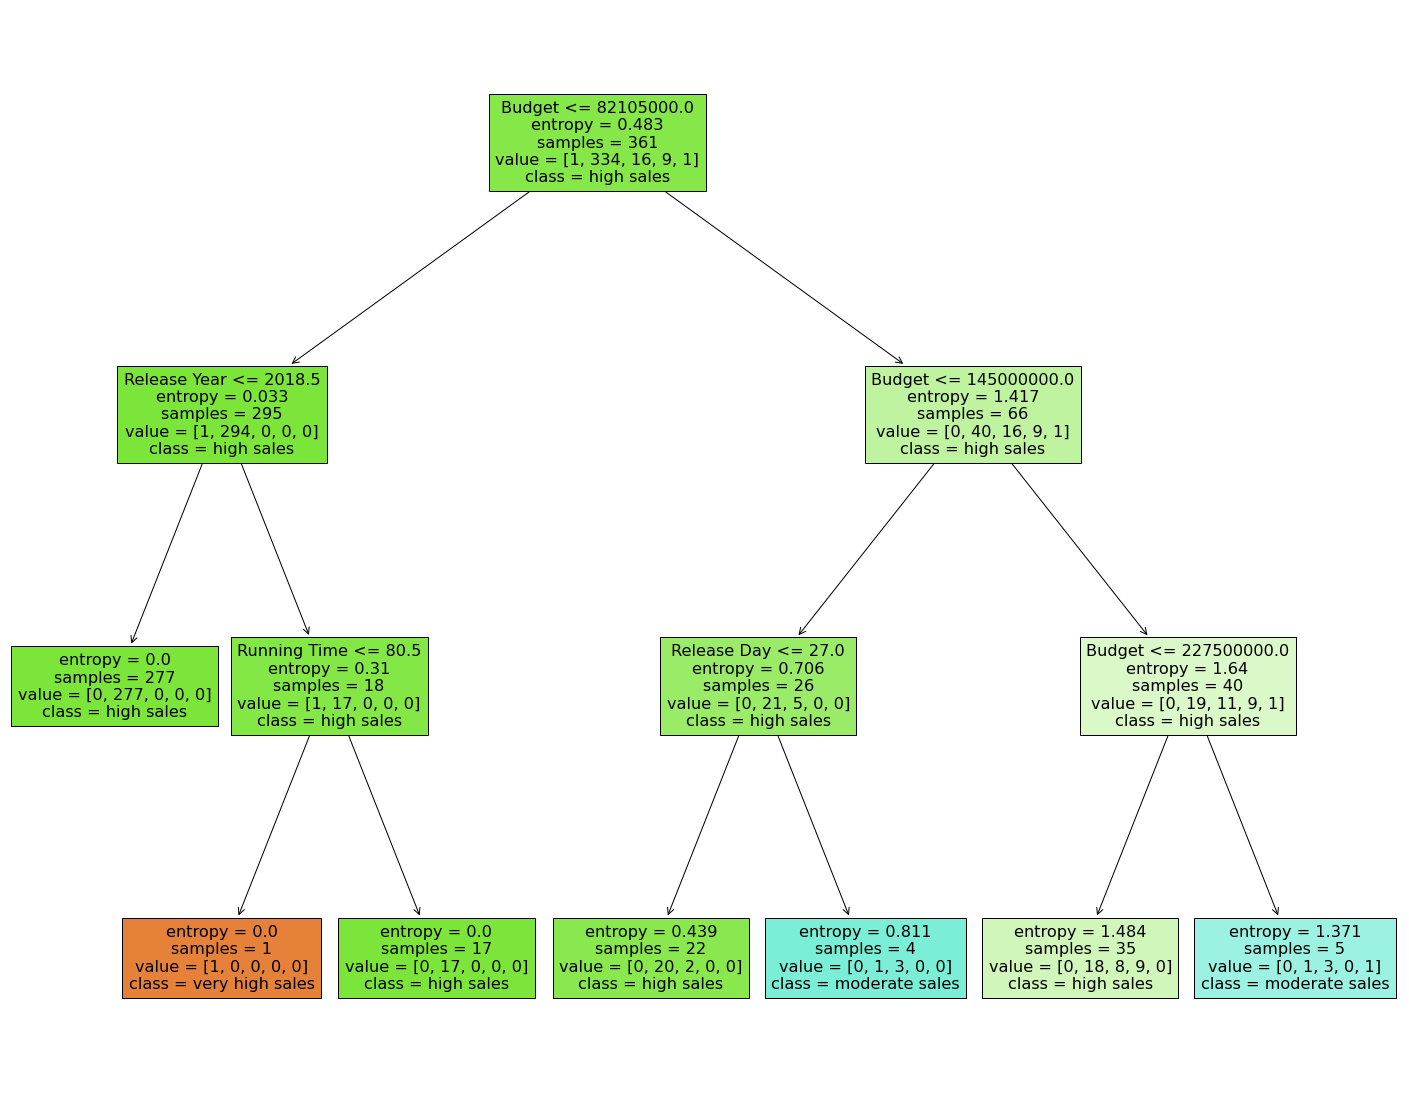

In [10]:
from sklearn.tree import export_graphviz, plot_tree
import matplotlib.pyplot as plt
feature_names = ['Running Time', 'Production Company', 'Budget', 'Country', 'Language','Release Year', 'Release Month', 'Release Day']
class_names = [ sales_label_map.get(i) for i in sales_label_map]

fig = plt.figure(figsize=(25,20))
_ =plot_tree(clf, feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)
